<h2>This notebook tackles pneumonia classification using CNN (Convolutional Neural Network). In addition, this will also experiment with threshold values. 

<br><br>Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli. Typically, symptoms include some combination of productive or dry cough, chest pain, fever and difficulty breathing. </h2>

<h3> Learn more from: <a href='https://www.who.int/news-room/fact-sheets/detail/pneumonia'>World Health Organization</a> </h3>
<br>Accuracy on testing set: 0.9104095563139932
<br>Precision on testing set: 0.9148936170212766
<br>Recall on testing set: 0.7962962962962963
<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Chest_X-ray_in_influenza_and_Haemophilus_influenzae_-_annotated.jpg/1200px-Chest_X-ray_in_influenza_and_Haemophilus_influenzae_-_annotated.jpg' alt='Pneumonia' height='800' width='300'> </center>
<p>Image Source: Wikipedia</p> 

In [162]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

<h2>Process the images and resize them to the preferred size </h2>

In [163]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

<h2>Preparing the training and testing data</h2>

In [164]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [165]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


<h2>Visualize training images</h2>

PNEUMONIA


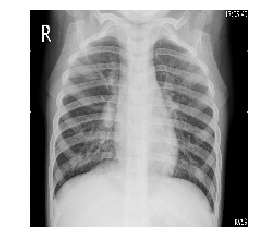

In [166]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

<h2 >We are incoprating the validation data into the training data because it does not contain enough examples. </h2>

In [167]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [168]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

Data augmentation 

In [169]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

<h2 >CNN (Convolutional Neural Network) </h2>
Image source: https://www.researchgate.net/publication/321286547/figure/download/fig6/AS:564402564472832@1511575465150/A-convolutional-neural-networks-CNN.png

![](https://www.researchgate.net/publication/321286547/figure/download/fig6/AS:564402564472832@1511575465150/A-convolutional-neural-networks-CNN.png)

In [170]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [171]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 200, 200, 256)     2560      
_________________________________________________________________
activation_25 (Activation)   (None, 200, 200, 256)     0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 100, 100, 256)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 100, 100, 256)     400       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 100, 100, 64)      147520    
_________________________________________________________________
activation_26 (Activation)   (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 50, 50, 64)       

In [172]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Train for 375 steps, validate on 937 samples
Epoch 1/15
375/375 [==============================] - 17s 46ms/step - loss: 0.6099 - acc: 0.7083 - val_loss: 0.7873 - val_acc: 0.7407
Epoch 2/15
375/375 [==============================] - 17s 45ms/step - loss: 0.4796 - acc: 0.7513 - val_loss: 0.3569 - val_acc: 0.8517
Epoch 3/15
375/375 [==============================] - 17s 45ms/step - loss: 0.4352 - acc: 0.7876 - val_loss: 0.3610 - val_acc: 0.8794
Epoch 4/15
375/375 [==============================] - 16s 44ms/step - loss: 0.3756 - acc: 0.8311 - val_loss: 0.3174 - val_acc: 0.8613
Epoch 5/15
375/375 [==============================] - 16s 43ms/step - loss: 0.3674 - acc: 0.8425 - val_loss: 0.3674 - val_acc: 0.8260
Epoch 6/15
375/375 [==============================] - 17s 46ms/step - loss: 0.3484 - acc: 0.8465 - val_loss: 0.3592 - val_acc: 0.8420
Epoch 7/15
375/375 [==============================] - 16s 44ms/step - loss: 0.3371 - acc: 0.8527 - val_loss: 0.2882 - val_acc: 0.8879
Epoch 8/15
375/37

In [173]:
model.evaluate(X_test, y_test)

1172/1172 [==============================] - 1s 1ms/sample - loss: 0.2115 - acc: 0.9164


[0.21145647225119554, 0.91638225]

<h2>Visualizing our training progress</h2>

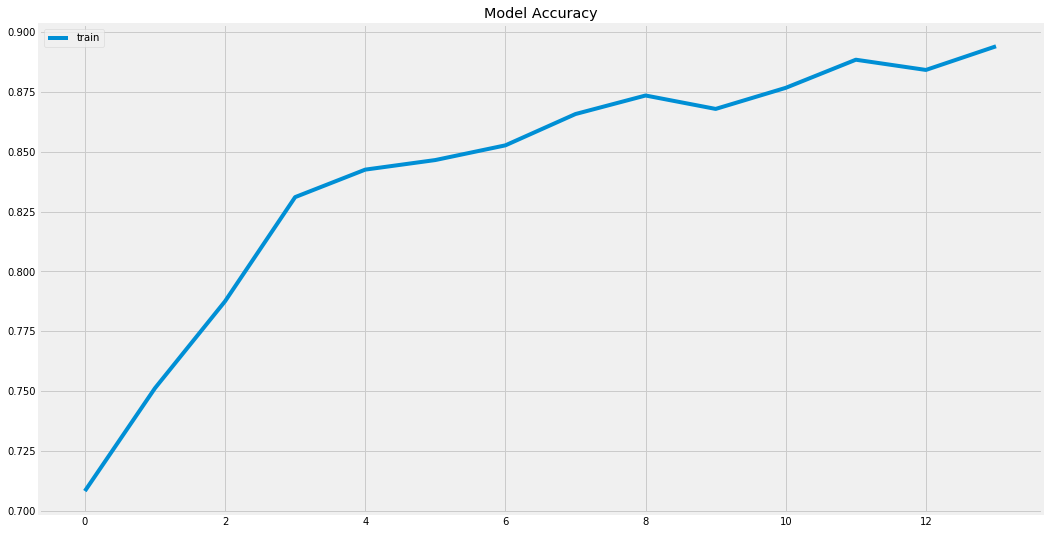

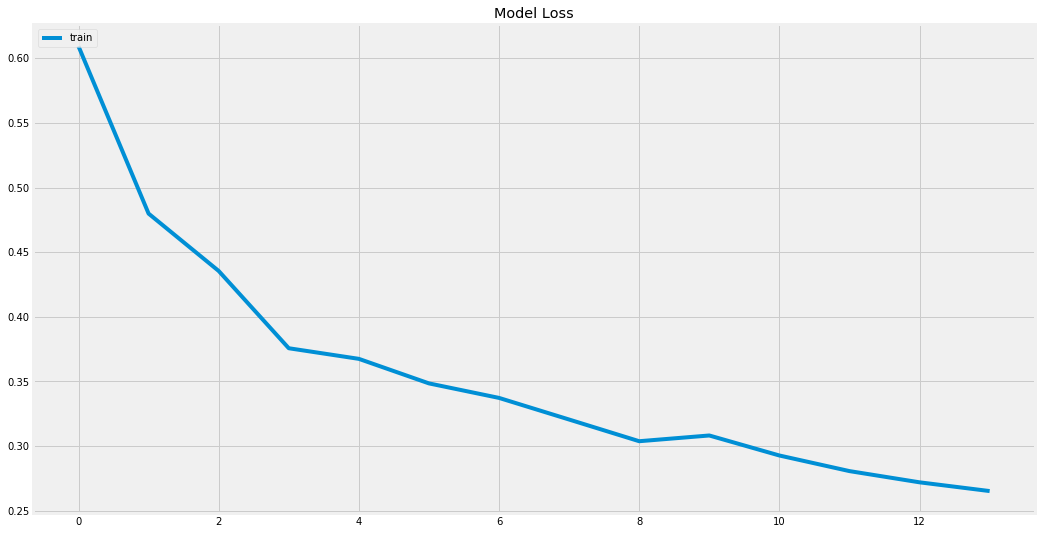

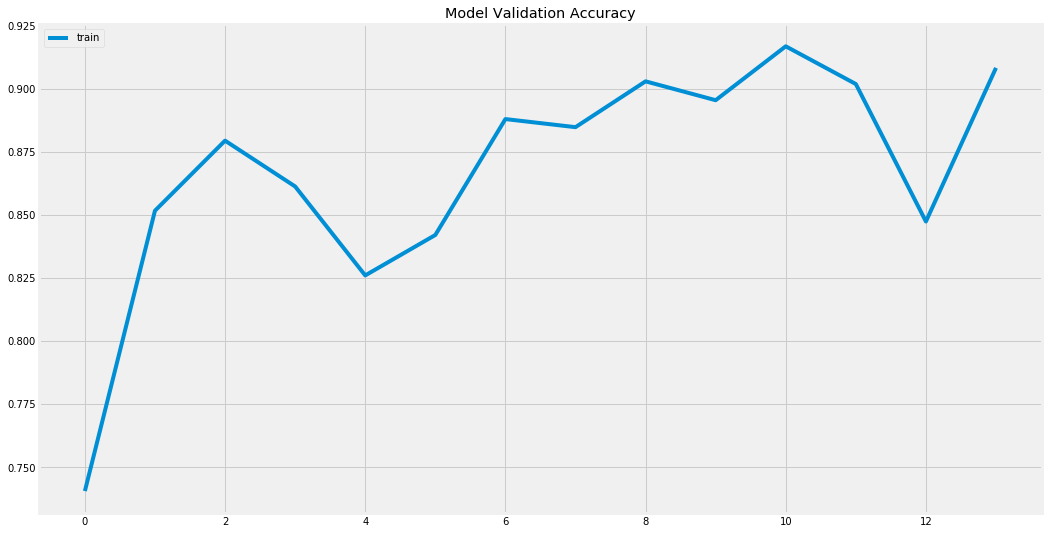

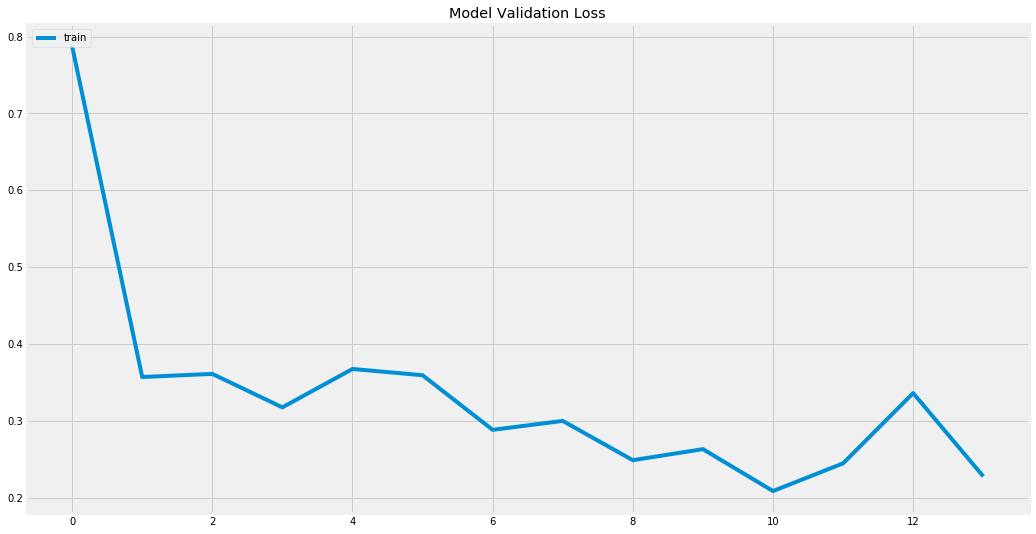

In [174]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

<h2>Prepare data for precision vs. recall and ROC</h2>

In [175]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

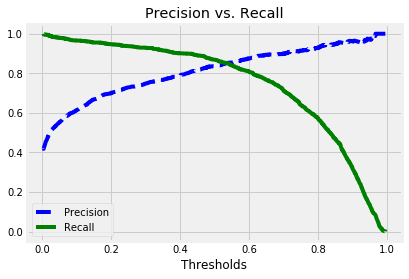

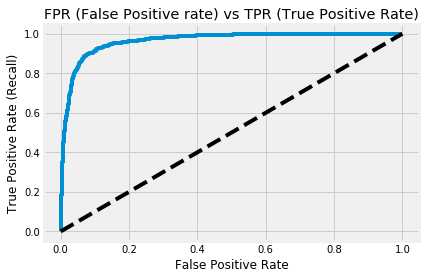

In [176]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [177]:
predictions = model.predict(X_test)

<h2>Set thresholds for our model, we want the results to be precise while not sacraficing too much recall </h2>

In [191]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [192]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9104095563139932
Precision on testing set: 0.9148936170212766
Recall on testing set: 0.7962962962962963


<h2>Plotting the confusion matrix. Here is how we interpet one. </h2>

Image source: https://silvrback.s3.amazonaws.com/uploads/4ab81a17-4a77-4e9e-b092-de5fac2afa07/confusionmatrix_large.png

![](https://silvrback.s3.amazonaws.com/uploads/4ab81a17-4a77-4e9e-b092-de5fac2afa07/confusionmatrix_large.png)

[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

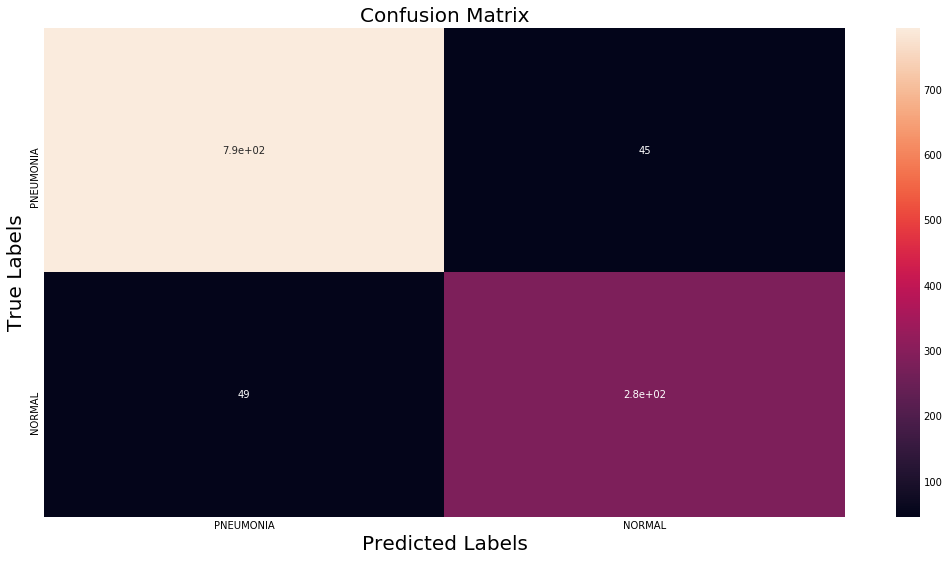

In [180]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

<h2>View some results from a sample of 25 images</h2>

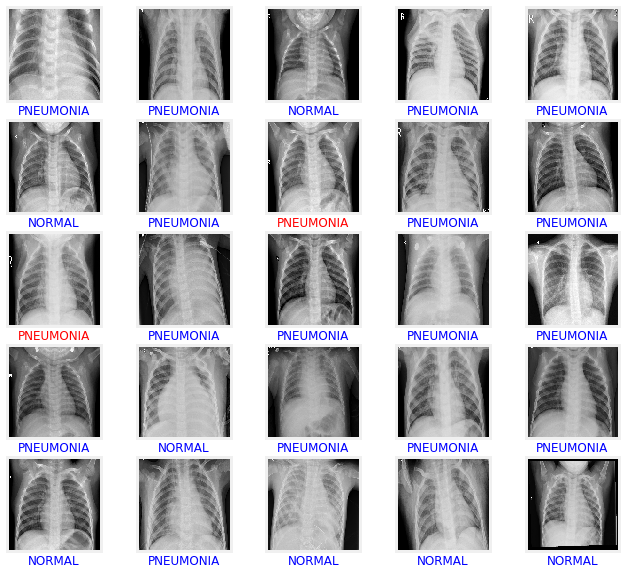

In [181]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

<h2>Download the model</h2>

In [182]:
 model.save('pneumonia_detection_ai_version_3.h5')

<h2>Reflection: </h2>
<h3> There are a lot of rooms to improve. If you have any questions or suggestions, please leave a comment below.</h3>